YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  22 of 22 completed



Median Cumulative Return (2012–2022) for All Communication Services Stocks: 397.37%
Number of Communication Services Stocks with Data: 22


<ipython-input-1-577df5603690>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, ax=ax2, palette="Blues_r")


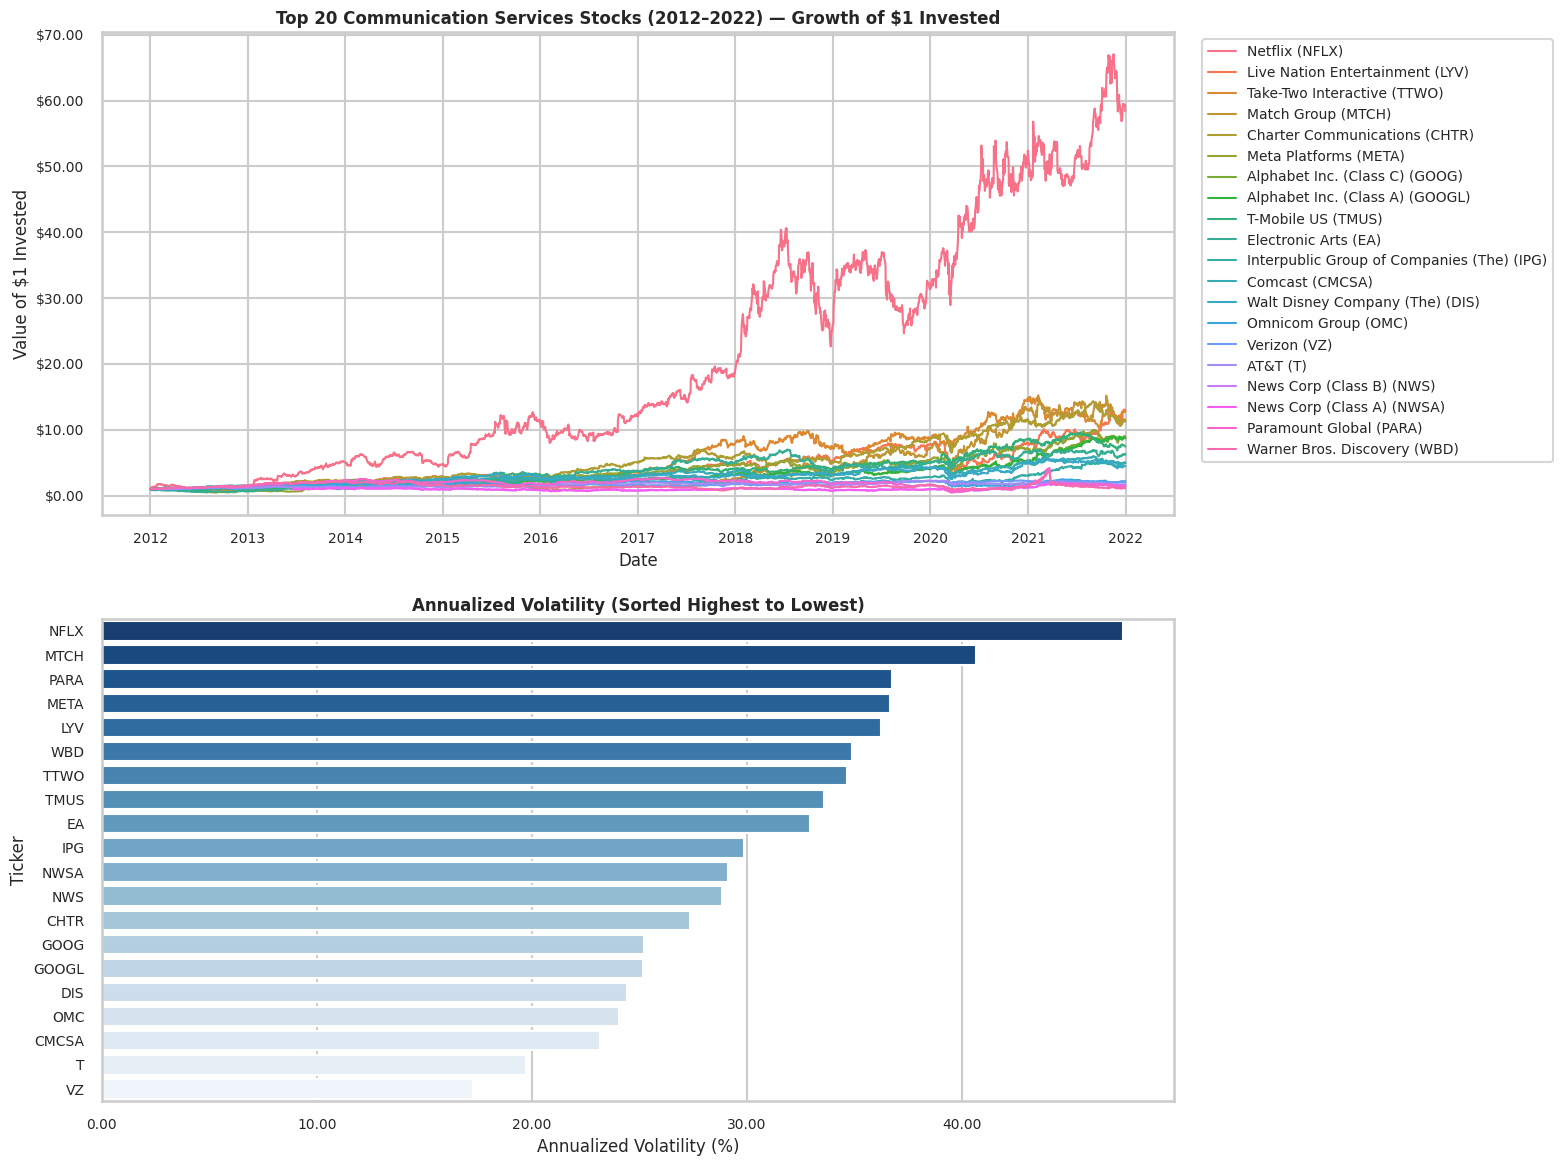

In [1]:
#In this section we need to find stocks within the communication services
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as mtick
import matplotlib as mpl

# 1. Font & styling (universal settings)
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
sns.set_theme(style="whitegrid", context="talk")

# 2. Fetch S&P 500 Communication Services tickers
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500 = pd.read_html(url, header=0)[0]
comm_stocks = sp500[sp500['GICS Sector'] == 'Communication Services']
tickers = comm_stocks['Symbol'].tolist()
name_map = dict(zip(comm_stocks['Symbol'], comm_stocks['Security']))

# 3. Date range & data download
start_date = datetime(2012, 1, 1)
end_date   = datetime(2022, 1, 1)
df_full = yf.download(tickers, start=start_date, end=end_date)

if "Adj Close" in df_full.columns.levels[0]:
    df_prices = df_full["Adj Close"]
else:
    df_prices = df_full["Close"]

# 4. Compute final return & annualized volatility
stats = {}
for ticker in df_prices.columns:
    series = df_prices[ticker].dropna()
    if len(series) < 2:
        continue

    final_return = (series.iloc[-1] / series.iloc[0]) - 1
    daily_ret = series.pct_change().dropna()
    if len(daily_ret) == 0:
        continue

    ann_vol = daily_ret.std() * np.sqrt(252)
    stats[ticker] = {"final_return": final_return, "annualized_vol": ann_vol}

stats_df = pd.DataFrame.from_dict(stats, orient='index')
stats_df.index.name = "Ticker"

# Print overall median
all_median = stats_df["final_return"].median()
print(f"\nMedian Cumulative Return (2012–2022) for All Communication Services Stocks: {all_median:.2%}")
print(f"Number of Communication Services Stocks with Data: {len(stats_df)}")

# 5. Top 20 by final return
stats_df.sort_values("final_return", ascending=False, inplace=True)
top_20 = stats_df.head(20)

# 6. Build '$1 invested' DataFrame
df_value = pd.DataFrame(index=df_prices.index)
for ticker in top_20.index:
    s = df_prices[ticker].dropna()
    if len(s) >= 2:
        df_value[ticker] = s / s.iloc[0]
df_value.dropna(how='all', inplace=True)

# 7. Subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

# --- TOP SUBPLOT: Growth of $1 ---
colors = sns.color_palette("husl", n_colors=len(df_value.columns))
for i, ticker in enumerate(df_value.columns):
    label = f"{name_map.get(ticker, 'Unknown')} ({ticker})"
    ax1.plot(df_value.index, df_value[ticker], label=label, linewidth=1.5, color=colors[i])

ax1.set_title("Top 20 Communication Services Stocks (2012–2022) — Growth of $1 Invested", fontsize=12, fontweight='bold')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Value of $1 Invested", fontsize=12)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('$%.2f'))
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

# Reduce tick label size on the top subplot
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

# --- BOTTOM SUBPLOT: Annualized Volatility ---
top_20_sorted_vol = top_20.sort_values("annualized_vol", ascending=False)
x = top_20_sorted_vol.index
y = top_20_sorted_vol["annualized_vol"] * 100  # convert to %
sns.barplot(x=y, y=x, ax=ax2, palette="Blues_r")
ax2.set_title("Annualized Volatility (Sorted Highest to Lowest)", fontsize=12, fontweight='bold')
ax2.set_xlabel("Annualized Volatility (%)", fontsize=12)
ax2.set_ylabel("Ticker", fontsize=12)
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn theme for aesthetics
sns.set_theme(style="whitegrid")

# 1. Get S&P 500 companies from Wikipedia and filter for the Communication Services sector
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
comm_df = sp500_table[sp500_table['GICS Sector'] == 'Communication Services']
comm_tickers = comm_df['Symbol'].tolist()
# Adjust tickers for yfinance formatting (e.g., "BRK.B" -> "BRK-B")
comm_tickers = [ticker.replace('.', '-') for ticker in comm_tickers]

# 2. Define the date range (2012-2022) and download data for communication services tickers
start_date = "2012-01-01"
end_date = "2022-01-01"
data = yf.download(comm_tickers, start=start_date, end=end_date, progress=False)

# 3. Calculate cumulative return and annualized volatility for each ticker
results = []
for ticker in comm_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue

        # Cumulative return: (final price / initial price) - 1
        cum_return = (series.iloc[-1] / series.iloc[0]) - 1

        # Daily returns and annualized volatility (std dev * sqrt(252 trading days))
        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)

        # Compute a simple return-to-risk ratio (higher is better)
        if volatility != 0:
            ratio = cum_return / volatility
        else:
            ratio = np.nan

        results.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_10y = pd.DataFrame(results)
print(_results_10y)


   Ticker  Cumulative Return  Volatility  Return-to-Risk
0   GOOGL           7.698826    0.251948       30.557230
1    GOOG           7.729763    0.252180       30.651728
2       T           0.716553    0.197208        3.633494
3    CHTR          10.400070    0.273495       38.026483
4   CMCSA           3.927039    0.231736       16.946199
5      EA           5.231593    0.329232       15.890270
6    FOXA           0.011350    0.383957        0.029559
7     FOX          -0.088503    0.371588       -0.238174
8     IPG           4.020455    0.298793       13.455669
9     LYV          12.023940    0.362686       33.152503
10   MTCH          10.444342    0.406794       25.674793
11   META           7.798064    0.366819       21.258588
12   NFLX          57.375971    0.475044      120.780357
13   NWSA           0.550500    0.291182        1.890568
14    NWS           0.587798    0.288385        2.038242
15    OMC           1.206436    0.240804        5.010023
16   PARA           0.292302   

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn theme for aesthetics
sns.set_theme(style="whitegrid")

# 1. Get S&P 500 companies from Wikipedia and filter for the Communication Services sector
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
comm_df = sp500_table[sp500_table['GICS Sector'] == 'Communication Services']
comm_tickers = comm_df['Symbol'].tolist()
comm_tickers = [ticker.replace('.', '-') for ticker in comm_tickers]

# 2. Define the 5-year date range (2017-2022) and download data
start_date = "2017-01-01"
end_date = "2022-01-01"
data = yf.download(comm_tickers, start=start_date, end=end_date, progress=False)

# 3. Calculate cumulative return and annualized volatility for each ticker
results_5y = []
for ticker in comm_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue

        # Cumulative return over 5 years
        cum_return = (series.iloc[-1] / series.iloc[0]) - 1

        # Annualized volatility
        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)

        # Return-to-Risk ratio
        ratio = np.nan if volatility == 0 else (cum_return / volatility)

        results_5y.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_5y = pd.DataFrame(results_5y)
print(_results_5y)


   Ticker  Cumulative Return  Volatility  Return-to-Risk
0   GOOGL           2.585401    0.270520        9.557170
1    GOOG           2.680757    0.269893        9.932666
2       T          -0.142372    0.236812       -0.601202
3    CHTR           1.281450    0.280926        4.561514
4   CMCSA           0.600888    0.267846        2.243412
5      EA           0.676555    0.313622        2.157235
6    FOXA           0.011349    0.383957        0.029559
7     FOX          -0.088503    0.371588       -0.238174
8     IPG           0.940657    0.347569        2.706393
9     LYV           3.368248    0.429447        7.843226
10   MTCH           7.018061    0.470839       14.905448
11   META           1.878231    0.331638        5.663501
12   NFLX           3.725390    0.381580        9.763074
13   NWSA           1.045241    0.313031        3.339095
14    NWS           0.998820    0.314740        3.173482
15    OMC           0.026655    0.290978        0.091606
16   PARA          -0.482191   

In [4]:
# Set seaborn theme for aesthetics
sns.set_theme(style="whitegrid")

# 1. Get S&P 500 companies from Wikipedia and filter for the Communication Services sector
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
comm_df = sp500_table[sp500_table['GICS Sector'] == 'Communication Services']
comm_tickers = comm_df['Symbol'].tolist()
comm_tickers = [ticker.replace('.', '-') for ticker in comm_tickers]

# 2. Define the date range (3 years: 2019-2022) and download data for communication services tickers
start_date = "2019-01-01"
end_date = "2022-01-01"
data = yf.download(comm_tickers, start=start_date, end=end_date, progress=False)

# 3. Calculate cumulative return and annualized volatility for each ticker
results_3y = []
for ticker in comm_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue

        # Cumulative return: (final price / initial price) - 1
        cum_return = (series.iloc[-1] / series.iloc[0]) - 1

        # Daily returns and annualized volatility (std dev * sqrt(252))
        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)

        # Return-to-Risk ratio (higher is better)
        ratio = np.nan if volatility == 0 else (cum_return / volatility)

        results_3y.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_3y = pd.DataFrame(results_3y)
print(_results_3y)


   Ticker  Cumulative Return  Volatility  Return-to-Risk
0   GOOGL           1.746843    0.296208        5.897356
1    GOOG           1.766735    0.295129        5.986313
2       T           0.084648    0.255689        0.331060
3    CHTR           1.263863    0.278336        4.540786
4   CMCSA           0.546892    0.284161        1.924586
5      EA           0.651523    0.332731        1.958107
6    FOXA           0.011349    0.383957        0.029559
7     FOX          -0.088502    0.371588       -0.238174
8     IPG           1.104842    0.391877        2.819357
9     LYV           1.477541    0.504665        2.927764
10   MTCH           2.120576    0.478247        4.434061
11   META           1.478995    0.353372        4.185375
12   NFLX           1.250766    0.381294        3.280318
13   NWSA           1.037784    0.351496        2.952479
14    NWS           1.015595    0.355605        2.855967
15    OMC           0.129179    0.333619        0.387204
16   PARA          -0.288186   

In [5]:
# Set seaborn theme for aesthetics
sns.set_theme(style="whitegrid")

# 1. Get S&P 500 companies from Wikipedia and filter for the tech sector
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
tech_df = sp500_table[sp500_table['GICS Sector'] == 'Communication Services']
tech_tickers = tech_df['Symbol'].tolist()
tech_tickers = [ticker.replace('.', '-') for ticker in tech_tickers]

# 2. Define the date range (1 year: 2021-01-01 to 2022-01-01) and download data
start_date = "2021-01-01"
end_date = "2022-01-01"
data = yf.download(tech_tickers, start=start_date, end=end_date, progress=False)

# 3. Calculate cumulative return and annualized volatility for each ticker
results_1y = []
for ticker in tech_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue

        # Cumulative return: (final price / initial price) - 1
        cum_return = (series.iloc[-1] / series.iloc[0]) - 1

        # Daily returns and annualized volatility (std dev * sqrt(252))
        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)

        # Return-to-Risk ratio (higher is better)
        ratio = np.nan if volatility == 0 else (cum_return / volatility)

        results_1y.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_1y = pd.DataFrame(results_1y)


In [6]:
# Rename columns for clarity
_results_10y = _results_10y.rename(columns={
    "Cumulative Return": "CumulativeReturn_10y",
    "Volatility": "Volatility_10y",
    "Return-to-Risk": "ReturnToRisk_10y"
})

_results_5y = _results_5y.rename(columns={
    "Cumulative Return": "CumulativeReturn_5y",
    "Volatility": "Volatility_5y",
    "Return-to-Risk": "ReturnToRisk_5y"
})

_results_3y = _results_3y.rename(columns={
    "Cumulative Return": "CumulativeReturn_3y",
    "Volatility": "Volatility_3y",
    "Return-to-Risk": "ReturnToRisk_3y"
})

_results_1y = _results_1y.rename(columns={
    "Cumulative Return": "CumulativeReturn_1y",
    "Volatility": "Volatility_1y",
    "Return-to-Risk": "ReturnToRisk_1y"
})


df_10y = _results_10y[["Ticker","CumulativeReturn_10y","Volatility_10y","ReturnToRisk_10y"]]
df_5y  = _results_5y[ ["Ticker","CumulativeReturn_5y","Volatility_5y","ReturnToRisk_5y"]]
df_3y  = _results_3y[ ["Ticker","CumulativeReturn_3y","Volatility_3y","ReturnToRisk_3y"]]
df_1y  = _results_1y[ ["Ticker","CumulativeReturn_1y","Volatility_1y","ReturnToRisk_1y"]]

merged_df = (
    df_10y.merge(df_5y, on="Ticker", how="inner")
          .merge(df_3y, on="Ticker", how="inner")
          .merge(df_1y, on="Ticker", how="inner")
)

print("Merged shape:", merged_df.shape)
print(merged_df.head())



Merged shape: (22, 13)
  Ticker  CumulativeReturn_10y  Volatility_10y  ReturnToRisk_10y  \
0  GOOGL              7.698826        0.251948         30.557230   
1   GOOG              7.729763        0.252180         30.651728   
2      T              0.716553        0.197208          3.633494   
3   CHTR             10.400070        0.273495         38.026483   
4  CMCSA              3.927039        0.231736         16.946199   

   CumulativeReturn_5y  Volatility_5y  ReturnToRisk_5y  CumulativeReturn_3y  \
0             2.585401       0.270520         9.557170             1.746843   
1             2.680757       0.269893         9.932666             1.766735   
2            -0.142372       0.236812        -0.601202             0.084648   
3             1.281450       0.280926         4.561514             1.263863   
4             0.600888       0.267846         2.243412             0.546892   

   Volatility_3y  ReturnToRisk_3y  CumulativeReturn_1y  Volatility_1y  \
0       0.296208    

In [7]:
# List out the columns for each metric type
cumret_cols = ["CumulativeReturn_10y","CumulativeReturn_5y","CumulativeReturn_3y","CumulativeReturn_1y"]
vol_cols    = ["Volatility_10y","Volatility_5y","Volatility_3y","Volatility_1y"]
rtr_cols    = ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]

def zscore(series):
    return (series - series.mean()) / series.std(ddof=0)

# We'll create new columns with z_ prefix
for col in cumret_cols + vol_cols + rtr_cols:
    if merged_df[col].std(ddof=0) == 0:
        # Handle edge case if a column has zero std
        merged_df["z_"+col] = 0
    else:
        merged_df["z_"+col] = zscore(merged_df[col])

# Invert volatility z-scores so that lower vol => higher is better
for col in vol_cols:
    merged_df["z_"+col] = -1.0 * merged_df["z_"+col]

metric_weights = {
    "CumulativeReturn": 0.4,  # 40%
    "Volatility":       0.3,  # 30%
    "ReturnToRisk":     0.3   # 30%
}

time_weights = {
    "10y": 0.4,
    "5y":  0.3,
    "3y":  0.2,
    "1y":  0.1
}

def compute_score(row):
    score = 0.0

    # For each time frame
    for tf in ["10y","5y","3y","1y"]:
        # Weighted sum of the three metrics in that time frame
        cr_col  = f"z_CumulativeReturn_{tf}"
        vol_col = f"z_Volatility_{tf}"
        rtr_col = f"z_ReturnToRisk_{tf}"

        # Sum for this time frame
        tf_sum = (metric_weights["CumulativeReturn"] * row[cr_col]
                  + metric_weights["Volatility"]       * row[vol_col]
                  + metric_weights["ReturnToRisk"]     * row[rtr_col])

        # Multiply by the time frame's weight
        score += time_weights[tf] * tf_sum

    return score

merged_df["FinalScore"] = merged_df.apply(compute_score, axis=1)

# Sort descending by FinalScore
merged_df.sort_values("FinalScore", ascending=False, inplace=True)


In [8]:
# Print the top 40
top_40 = merged_df.head(40)
print(top_40[["Ticker","FinalScore"]])

   Ticker  FinalScore
12   NFLX    1.181670
1    GOOG    0.889093
0   GOOGL    0.864396
3    CHTR    0.431415
10   MTCH    0.410523
9     LYV    0.217203
11   META    0.164553
18   TTWO    0.123474
19     VZ    0.077889
4   CMCSA    0.063777
8     IPG    0.024621
17   TMUS   -0.013822
13   NWSA   -0.070928
14    NWS   -0.078641
20    DIS   -0.130405
2       T   -0.155451
5      EA   -0.179533
15    OMC   -0.235501
7     FOX   -0.722235
6    FOXA   -0.723892
21    WBD   -0.956803
16   PARA   -1.181402


In [9]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00


In [10]:
import optuna

# 1) Rename columns in each DataFrame for clarity
_results_10y = _results_10y.rename(columns={
    "Cumulative Return": "CumulativeReturn_10y",
    "Volatility": "Volatility_10y",
    "Return-to-Risk": "ReturnToRisk_10y"
})
_results_5y = _results_5y.rename(columns={
    "Cumulative Return": "CumulativeReturn_5y",
    "Volatility": "Volatility_5y",
    "Return-to-Risk": "ReturnToRisk_5y"
})
_results_3y = _results_3y.rename(columns={
    "Cumulative Return": "CumulativeReturn_3y",
    "Volatility": "Volatility_3y",
    "Return-to-Risk": "ReturnToRisk_3y"
})
_results_1y = _results_1y.rename(columns={
    "Cumulative Return": "CumulativeReturn_1y",
    "Volatility": "Volatility_1y",
    "Return-to-Risk": "ReturnToRisk_1y"
})

# 2) Merge them all into one DataFrame
df_10y = _results_10y[["Ticker","CumulativeReturn_10y","Volatility_10y","ReturnToRisk_10y"]]
df_5y  = _results_5y[ ["Ticker","CumulativeReturn_5y","Volatility_5y","ReturnToRisk_5y"]]
df_3y  = _results_3y[ ["Ticker","CumulativeReturn_3y","Volatility_3y","ReturnToRisk_3y"]]
df_1y  = _results_1y[ ["Ticker","CumulativeReturn_1y","Volatility_1y","ReturnToRisk_1y"]]

merged_df = (df_10y.merge(df_5y, on="Ticker", how="inner")
                     .merge(df_3y, on="Ticker", how="inner")
                     .merge(df_1y, on="Ticker", how="inner"))

# 3) Standardize each metric so higher = better.
#    For Volatility, invert it so lower vol => higher is better.
def zscore(series):
    return (series - series.mean()) / series.std(ddof=0)

# List columns for each metric type
cumret_cols = ["CumulativeReturn_10y","CumulativeReturn_5y","CumulativeReturn_3y","CumulativeReturn_1y"]
vol_cols    = ["Volatility_10y","Volatility_5y","Volatility_3y","Volatility_1y"]
rtr_cols    = ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]

for col in cumret_cols + vol_cols + rtr_cols:
    if merged_df[col].std(ddof=0) == 0:
        merged_df["z_"+col] = 0
    else:
        merged_df["z_"+col] = zscore(merged_df[col])

# Invert vol columns
for col in vol_cols:
    merged_df["z_"+col] = -1.0 * merged_df["z_"+col]

# 4) Define an Optuna objective function to find the best weights
def objective(trial):
    # (A) Suggest weights for metrics (Cumulative Return, Volatility, Return-to-Risk)
    w_cr  = trial.suggest_float("w_cr",  0.0, 1.0)
    w_vol = trial.suggest_float("w_vol", 0.0, 1.0)
    w_rtr = trial.suggest_float("w_rtr", 0.0, 1.0)
    sum_m = w_cr + w_vol + w_rtr
    if sum_m == 0:
        return -9999
    w_cr  /= sum_m
    w_vol /= sum_m
    w_rtr /= sum_m

    # (B) Suggest weights for each time frame (10y, 5y, 3y, 1y)
    w_10y = trial.suggest_float("w_10y", 0.0, 1.0)
    w_5y  = trial.suggest_float("w_5y",  0.0, 1.0)
    w_3y  = trial.suggest_float("w_3y",  0.0, 1.0)
    w_1y  = trial.suggest_float("w_1y",  0.0, 1.0)
    sum_tf = w_10y + w_5y + w_3y + w_1y
    if sum_tf == 0:
        return -9999
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf

    # (C) Compute combined_score for each stock
    df = merged_df.copy()

    def combined_score(row):
        # Weighted sum of z-scores within each time frame, then multiplied by that time frame's weight
        score_10y = w_10y * (w_cr*row["z_CumulativeReturn_10y"] + w_vol*row["z_Volatility_10y"] + w_rtr*row["z_ReturnToRisk_10y"])
        score_5y  = w_5y  * (w_cr*row["z_CumulativeReturn_5y"]  + w_vol*row["z_Volatility_5y"]  + w_rtr*row["z_ReturnToRisk_5y"])
        score_3y  = w_3y  * (w_cr*row["z_CumulativeReturn_3y"]  + w_vol*row["z_Volatility_3y"]  + w_rtr*row["z_ReturnToRisk_3y"])
        score_1y  = w_1y  * (w_cr*row["z_CumulativeReturn_1y"]  + w_vol*row["z_Volatility_1y"]  + w_rtr*row["z_ReturnToRisk_1y"])
        return score_10y + score_5y + score_3y + score_1y

    df["combined_score"] = df.apply(combined_score, axis=1)

    # (D) Pick the top 10 stocks by combined_score
    top_10 = df.nlargest(10, "combined_score")

    # (E) Define an objective measure to maximize:
    #     For example, the average of 'ReturnToRisk_x' (the raw columns) across 10y,5y,3y,1y for these top 10
    #     If you don't have them, you can adapt to your own measure.
    if all(col in df.columns for col in ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]):
        avg_rtr_10y = top_10["ReturnToRisk_10y"].mean()
        avg_rtr_5y  = top_10["ReturnToRisk_5y"].mean()
        avg_rtr_3y  = top_10["ReturnToRisk_3y"].mean()
        avg_rtr_1y  = top_10["ReturnToRisk_1y"].mean()
        # Final objective: average across these 4
        objective_value = np.mean([avg_rtr_10y, avg_rtr_5y, avg_rtr_3y, avg_rtr_1y])
    else:
        # If you only have z_ columns or want a different measure, adapt here.
        # We'll just average z_ReturnToRisk columns as a fallback:
        avg_zrtr_10y = top_10["z_ReturnToRisk_10y"].mean()
        avg_zrtr_5y  = top_10["z_ReturnToRisk_5y"].mean()
        avg_zrtr_3y  = top_10["z_ReturnToRisk_3y"].mean()
        avg_zrtr_1y  = top_10["z_ReturnToRisk_1y"].mean()
        objective_value = np.mean([avg_zrtr_10y, avg_zrtr_5y, avg_zrtr_3y, avg_zrtr_1y])

    # We want to maximize the objective_value
    return objective_value
optuna.logging.set_verbosity(optuna.logging.WARNING)
# 5) Run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)
print("Best objective value:", study.best_value)

# 6) With best_params in hand, you can re-run the 'combined_score' logic
#    to see which stocks come out on top.
# Extract the best hyperparameters
best_params = study.best_params

# Unpack metric weights
w_cr  = best_params["w_cr"]
w_vol = best_params["w_vol"]
w_rtr = best_params["w_rtr"]
sum_m = w_cr + w_vol + w_rtr
if sum_m == 0:
    w_cr = w_vol = w_rtr = 1/3.0
else:
    w_cr  /= sum_m
    w_vol /= sum_m
    w_rtr /= sum_m

# Unpack time-frame weights
w_10y = best_params["w_10y"]
w_5y  = best_params["w_5y"]
w_3y  = best_params["w_3y"]
w_1y  = best_params["w_1y"]
sum_tf = w_10y + w_5y + w_3y + w_1y
if sum_tf == 0:
    w_10y = 0.4
    w_5y  = 0.3
    w_3y  = 0.2
    w_1y  = 0.1
else:
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf

# Re-compute the combined_score with these best weights
df = merged_df.copy()

def combined_score(row):
    score_10y = w_10y * (
        w_cr  * row["z_CumulativeReturn_10y"] +
        w_vol * row["z_Volatility_10y"]       +
        w_rtr * row["z_ReturnToRisk_10y"]
    )
    score_5y = w_5y * (
        w_cr  * row["z_CumulativeReturn_5y"] +
        w_vol * row["z_Volatility_5y"]       +
        w_rtr * row["z_ReturnToRisk_5y"]
    )
    score_3y = w_3y * (
        w_cr  * row["z_CumulativeReturn_3y"] +
        w_vol * row["z_Volatility_3y"]       +
        w_rtr * row["z_ReturnToRisk_3y"]
    )
    score_1y = w_1y * (
        w_cr  * row["z_CumulativeReturn_1y"] +
        w_vol * row["z_Volatility_1y"]       +
        w_rtr * row["z_ReturnToRisk_1y"]
    )
    return score_10y + score_5y + score_3y + score_1y

df["combined_score"] = df.apply(combined_score, axis=1)

# Sort descending by combined_score
df.sort_values("combined_score", ascending=False, inplace=True)

# Grab the top 20
top_20 = df.head(20)

print("\n=== Top 20 Stocks Using Optuna-Tuned Weights ===")
print(top_20[["Ticker","combined_score"]])


Best hyperparameters: {'w_cr': 0.9513223681899204, 'w_vol': 0.5504027266408199, 'w_rtr': 0.9278484646545255, 'w_10y': 0.7167029796362998, 'w_5y': 0.9387205718062273, 'w_3y': 0.4757956460508469, 'w_1y': 0.28124238853518096}
Best objective value: 12.271323930331505

=== Top 20 Stocks Using Optuna-Tuned Weights ===
   Ticker  combined_score
12   NFLX        1.224994
1    GOOG        1.001397
0   GOOGL        0.968732
10   MTCH        0.752093
9     LYV        0.387268
3    CHTR        0.381781
11   META        0.252932
18   TTWO        0.178302
8     IPG        0.046591
17   TMUS       -0.038125
4   CMCSA       -0.048974
13   NWSA       -0.063628
14    NWS       -0.074977
19     VZ       -0.134049
5      EA       -0.220190
20    DIS       -0.243192
15    OMC       -0.352469
2       T       -0.359085
6    FOXA       -0.720337
7     FOX       -0.741801


<ipython-input-11-a5b64f500fbc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


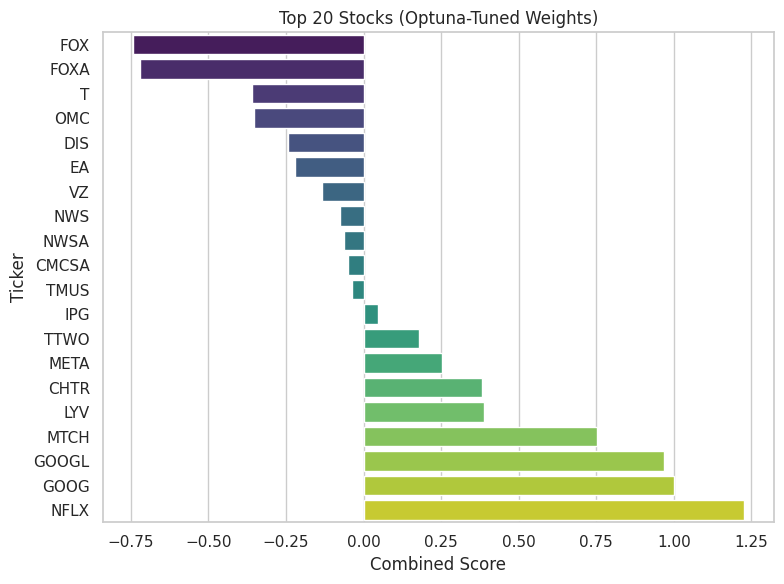

In [11]:
# Assuming 'top_20' is your DataFrame with columns: 'Ticker' and 'combined_score'
# Sort again if needed
top_20_sorted = top_20.sort_values("combined_score", ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_20_sorted,
    x="combined_score",
    y="Ticker",
    palette="viridis"  # or any palette you like
)

plt.title("Top 20 Stocks (Optuna-Tuned Weights)")
plt.xlabel("Combined Score")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()


In [12]:
!pip install yahooquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.1
    Uninstalling lxml-5.3.1:
      Successfully uninstalled lxml-5.3.1


In [13]:
import pandas as pd
import numpy as np
from yahooquery import Ticker

# Assume top_20 is your DataFrame with a "Ticker" column
# top_20 = pd.DataFrame({"Ticker": ["AAPL","MSFT","GOOG", ...]})

fundamental_rows = []

for tkr in top_20['Ticker']:
    try:
        ticker_obj = Ticker(tkr)

        # 1) Fetch quarterly income statement only
        inc_stmt_raw = ticker_obj.income_statement(frequency='q')

        # 2) Convert dict -> DataFrame if needed
        if isinstance(inc_stmt_raw, dict):
            inc_stmt_q = inc_stmt_raw.get(tkr, pd.DataFrame())
        else:
            inc_stmt_q = inc_stmt_raw

        # 3) Fix MultiIndex or missing 'symbol'
        if not inc_stmt_q.empty and 'symbol' not in inc_stmt_q.columns:
            inc_stmt_q = inc_stmt_q.reset_index()
        if 'symbol' not in inc_stmt_q.columns:
            inc_stmt_q['symbol'] = tkr

        # 4) Filter rows from 2021-01-01 onward (to capture more quarters)
        inc_stmt_q = inc_stmt_q[inc_stmt_q['asOfDate'] >= '2021-01-01']
        inc_stmt_q.sort_values('asOfDate', ascending=False, inplace=True)

        if inc_stmt_q.empty:
            print(f"No income statement data for {tkr} since 2021-01-01. Skipping.")
            continue

        # 5) Sum the last 4 quarters for TTM
        inc_stmt_ttm = inc_stmt_q.head(4)
        ttm_revenue    = inc_stmt_ttm.get('TotalRevenue', pd.Series()).sum()
        ttm_net_income = inc_stmt_ttm.get('NetIncome', pd.Series()).sum()

        # 6) Compute TTM Net Margin
        ttm_net_margin = np.nan
        if ttm_revenue and ttm_revenue != 0:
            ttm_net_margin = ttm_net_income / ttm_revenue

        # 7) Snapshot P/E from summary_detail
        summary = ticker_obj.summary_detail.get(tkr, {})
        trailing_pe = summary.get('trailingPE', np.nan)

        # 8) Store results (no Debt/Equity or TTM_ROE)
        fundamental_rows.append({
            'Ticker': tkr,
            'TTM_Revenue': ttm_revenue,
            'TTM_NetIncome': ttm_net_income,
            'TTM_NetMargin': ttm_net_margin,
            'TrailingPE': trailing_pe
        })

    except Exception as e:
        print(f"Error processing {tkr}: {e}")

# 9) Create DataFrame
fund_df = pd.DataFrame(fundamental_rows)

# 10) Round numeric columns to 2 decimals for cleaner display
cols_to_round = ['TTM_Revenue','TTM_NetIncome','TTM_NetMargin','TrailingPE']
for col in cols_to_round:
    if col in fund_df.columns:
        fund_df[col] = fund_df[col].round(2)

print("\n=== Aggregated Fundamental Data (TTM from 2021-01-01) ===")
print(fund_df)



=== Aggregated Fundamental Data (TTM from 2021-01-01) ===
   Ticker   TTM_Revenue  TTM_NetIncome  TTM_NetMargin  TrailingPE
0    NFLX  5.907218e+10   1.294375e+10           0.22       49.50
1    GOOG  5.347550e+11   1.529550e+11           0.29       21.42
2   GOOGL  5.347550e+11   1.529550e+11           0.29       21.18
3    MTCH  5.235033e+09   8.460400e+08           0.16       15.70
4     LYV  3.648830e+10   1.549079e+09           0.04       52.32
5    CHTR  8.280600e+10   7.829000e+09           0.09       10.40
6    META  2.534750e+11   9.888600e+10           0.39       28.02
7    TTWO  8.163400e+09  -4.146400e+09          -0.51         NaN
8     IPG  1.617750e+10   1.054100e+09           0.07       14.97
9    TMUS  1.234340e+11   1.737900e+10           0.14       27.95
10  CMCSA  1.877160e+11   2.459800e+10           0.13        8.67
11   NWSA  1.506800e+10   7.480000e+08           0.05       38.16
12    NWS  1.506800e+10   7.480000e+08           0.05       43.04
13     VZ  2.0379

merged_df shape (performance only): (22, 13)
final_merged shape (performance + fundamentals): (22, 32)
  Ticker  CumulativeReturn_10y  Volatility_10y  ReturnToRisk_10y  \
0  GOOGL              7.698826        0.251948         30.557230   
1   GOOG              7.729763        0.252180         30.651728   
2      T              0.716553        0.197208          3.633494   
3   CHTR             10.400070        0.273495         38.026483   
4  CMCSA              3.927039        0.231736         16.946199   

   CumulativeReturn_5y  Volatility_5y  ReturnToRisk_5y  CumulativeReturn_3y  \
0             2.585401       0.270520         9.557170             1.746843   
1             2.680757       0.269893         9.932666             1.766735   
2            -0.142372       0.236812        -0.601202             0.084648   
3             1.281450       0.280926         4.561514             1.263863   
4             0.600888       0.267846         2.243412             0.546892   

   Volatility

<ipython-input-14-761da1b491e3>:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


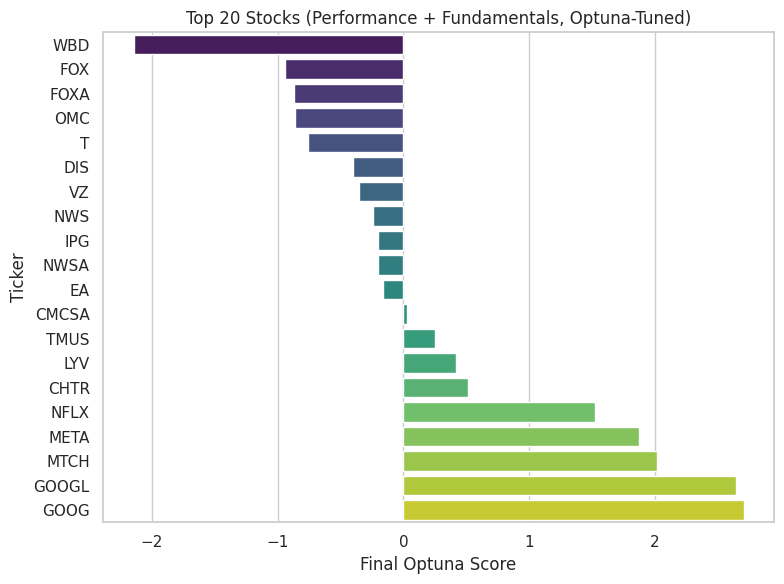

In [14]:

#===============================================================
# 1) RENAME & MERGE TIME-FRAME PERFORMANCE DATA
#===============================================================
# Rename columns in each DataFrame for clarity
_results_10y = _results_10y.rename(columns={
    "Cumulative Return": "CumulativeReturn_10y",
    "Volatility":       "Volatility_10y",
    "Return-to-Risk":   "ReturnToRisk_10y"
})
_results_5y = _results_5y.rename(columns={
    "Cumulative Return": "CumulativeReturn_5y",
    "Volatility":       "Volatility_5y",
    "Return-to-Risk":   "ReturnToRisk_5y"
})
_results_3y = _results_3y.rename(columns={
    "Cumulative Return": "CumulativeReturn_3y",
    "Volatility":       "Volatility_3y",
    "Return-to-Risk":   "ReturnToRisk_3y"
})
_results_1y = _results_1y.rename(columns={
    "Cumulative Return": "CumulativeReturn_1y",
    "Volatility":       "Volatility_1y",
    "Return-to-Risk":   "ReturnToRisk_1y"
})

# Merge all time frames into one DataFrame
df_10y = _results_10y[["Ticker","CumulativeReturn_10y","Volatility_10y","ReturnToRisk_10y"]]
df_5y  = _results_5y[ ["Ticker","CumulativeReturn_5y","Volatility_5y","ReturnToRisk_5y"]]
df_3y  = _results_3y[ ["Ticker","CumulativeReturn_3y","Volatility_3y","ReturnToRisk_3y"]]
df_1y  = _results_1y[ ["Ticker","CumulativeReturn_1y","Volatility_1y","ReturnToRisk_1y"]]

merged_df = (
    df_10y.merge(df_5y, on="Ticker", how="inner")
          .merge(df_3y, on="Ticker", how="inner")
          .merge(df_1y, on="Ticker", how="inner")
)

print("merged_df shape (performance only):", merged_df.shape)

#===============================================================
# 2) STANDARDIZE PERFORMANCE COLUMNS (Z-SCORES)
#===============================================================
def zscore(series):
    if series.std(ddof=0) == 0:
        return pd.Series([0]*len(series), index=series.index)
    return (series - series.mean()) / series.std(ddof=0)

# Identify performance columns
cumret_cols = ["CumulativeReturn_10y","CumulativeReturn_5y","CumulativeReturn_3y","CumulativeReturn_1y"]
vol_cols    = ["Volatility_10y","Volatility_5y","Volatility_3y","Volatility_1y"]
rtr_cols    = ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]

# Z-score each column, invert volatility
for col in cumret_cols + vol_cols + rtr_cols:
    merged_df[f"z_{col}"] = zscore(merged_df[col])

for col in vol_cols:
    merged_df[f"z_{col}"] = -1.0 * merged_df[f"z_{col}"]  # lower vol => higher score

#===============================================================
# 3) MERGE WITH FUNDAMENTALS & STANDARDIZE
#===============================================================
# 'fund_df' has columns: ["Ticker","TTM_Revenue","TTM_NetIncome","TTM_NetMargin","TrailingPE"]
final_merged = merged_df.merge(fund_df, on="Ticker", how="left")

def safe_zscore(series):
    if series.std(ddof=0) == 0:
        return pd.Series([0]*len(series), index=series.index)
    return (series - series.mean()) / series.std(ddof=0)

# TTM_Revenue, TTM_NetMargin => higher is better
final_merged["z_TTM_Revenue"] = safe_zscore(final_merged["TTM_Revenue"].fillna(0))
final_merged["z_TTM_NetMargin"] = safe_zscore(final_merged["TTM_NetMargin"].fillna(0))

# TrailingPE => lower is better => invert after z-score
z_pe = safe_zscore(final_merged["TrailingPE"].fillna(9999))  # large fill for missing
final_merged["z_TrailingPE"] = -1.0 * z_pe

print("final_merged shape (performance + fundamentals):", final_merged.shape)
print(final_merged.head())

#===============================================================
# 4) DEFINE OPTUNA OBJECTIVE INCORPORATING PERFORMANCE + FUNDAMENTALS
#===============================================================
def objective(trial):
    # A) Performance metric weights
    w_cr  = trial.suggest_float("w_cr",  0.0, 1.0)
    w_vol = trial.suggest_float("w_vol", 0.0, 1.0)
    w_rtr = trial.suggest_float("w_rtr", 0.0, 1.0)
    sum_perf = w_cr + w_vol + w_rtr
    if sum_perf == 0:
        return -9999
    w_cr  /= sum_perf
    w_vol /= sum_perf
    w_rtr /= sum_perf

    # B) Fundamental metric weights
    w_rev    = trial.suggest_float("w_rev",    0.0, 1.0)
    w_margin = trial.suggest_float("w_margin", 0.0, 1.0)
    w_pe     = trial.suggest_float("w_pe",     0.0, 1.0)
    sum_fund = w_rev + w_margin + w_pe
    if sum_fund == 0:
        return -9999
    w_rev    /= sum_fund
    w_margin /= sum_fund
    w_pe     /= sum_fund

    # C) Time-frame weights
    w_10y = trial.suggest_float("w_10y", 0.0, 1.0)
    w_5y  = trial.suggest_float("w_5y",  0.0, 1.0)
    w_3y  = trial.suggest_float("w_3y",  0.0, 1.0)
    w_1y  = trial.suggest_float("w_1y",  0.0, 1.0)
    sum_tf = w_10y + w_5y + w_3y + w_1y
    if sum_tf == 0:
        return -9999
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf

    df = final_merged.copy()

    def combined_score(row):
        # PERFORMANCE
        perf_10y = (w_cr*row["z_CumulativeReturn_10y"] + w_vol*row["z_Volatility_10y"] + w_rtr*row["z_ReturnToRisk_10y"]) * w_10y
        perf_5y  = (w_cr*row["z_CumulativeReturn_5y"]  + w_vol*row["z_Volatility_5y"]  + w_rtr*row["z_ReturnToRisk_5y"])  * w_5y
        perf_3y  = (w_cr*row["z_CumulativeReturn_3y"]  + w_vol*row["z_Volatility_3y"]  + w_rtr*row["z_ReturnToRisk_3y"])  * w_3y
        perf_1y  = (w_cr*row["z_CumulativeReturn_1y"]  + w_vol*row["z_Volatility_1y"]  + w_rtr*row["z_ReturnToRisk_1y"])  * w_1y
        perf_sum = perf_10y + perf_5y + perf_3y + perf_1y

        # FUNDAMENTALS
        fund_sum = (w_rev*row["z_TTM_Revenue"]
                    + w_margin*row["z_TTM_NetMargin"]
                    + w_pe*row["z_TrailingPE"])

        return perf_sum + fund_sum

    df["combined_score"] = df.apply(combined_score, axis=1)

    # Pick top 10
    top_10 = df.nlargest(10, "combined_score")

    # Example objective: average ReturnToRisk_10y + average z_TTM_NetMargin
    avg_rtr_10y   = top_10["ReturnToRisk_10y"].mean()
    avg_netmargin = top_10["z_TTM_NetMargin"].mean()
    objective_value = avg_rtr_10y + avg_netmargin
    return objective_value

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("\nBest hyperparameters:", study.best_params)
print("Best objective value:", study.best_value)

#===============================================================
# 5) RE-APPLY BEST WEIGHTS & PRINT TOP 20
#===============================================================
best = study.best_params

# Extract performance metric weights
w_cr, w_vol, w_rtr = best["w_cr"], best["w_vol"], best["w_rtr"]
sum_perf = w_cr + w_vol + w_rtr
if sum_perf > 0:
    w_cr  /= sum_perf
    w_vol /= sum_perf
    w_rtr /= sum_perf

# Extract fundamental metric weights
w_rev, w_margin, w_pe = best["w_rev"], best["w_margin"], best["w_pe"]
sum_fund = w_rev + w_margin + w_pe
if sum_fund > 0:
    w_rev    /= sum_fund
    w_margin /= sum_fund
    w_pe     /= sum_fund

# Extract time-frame weights
w_10y, w_5y, w_3y, w_1y = best["w_10y"], best["w_5y"], best["w_3y"], best["w_1y"]
sum_tf = w_10y + w_5y + w_3y + w_1y
if sum_tf > 0:
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf

def final_score(row):
    perf_10y = (w_cr*row["z_CumulativeReturn_10y"] + w_vol*row["z_Volatility_10y"] + w_rtr*row["z_ReturnToRisk_10y"]) * w_10y
    perf_5y  = (w_cr*row["z_CumulativeReturn_5y"]  + w_vol*row["z_Volatility_5y"]  + w_rtr*row["z_ReturnToRisk_5y"])  * w_5y
    perf_3y  = (w_cr*row["z_CumulativeReturn_3y"]  + w_vol*row["z_Volatility_3y"]  + w_rtr*row["z_ReturnToRisk_3y"])  * w_3y
    perf_1y  = (w_cr*row["z_CumulativeReturn_1y"]  + w_vol*row["z_Volatility_1y"]  + w_rtr*row["z_ReturnToRisk_1y"])  * w_1y
    perf_sum = perf_10y + perf_5y + perf_3y + perf_1y

    fund_sum = (w_rev*row["z_TTM_Revenue"]
                + w_margin*row["z_TTM_NetMargin"]
                + w_pe*row["z_TrailingPE"])

    return perf_sum + fund_sum

final_merged["FinalOptunaScore"] = final_merged.apply(final_score, axis=1)
final_merged.sort_values("FinalOptunaScore", ascending=False, inplace=True)

top_20 = final_merged.head(20).copy()
print("\n=== Final Top 20 After Performance + Fundamentals Optuna ===")
print(top_20[["Ticker","FinalOptunaScore","ReturnToRisk_10y","TTM_NetMargin","TrailingPE"]])

# Optional quick barplot
import seaborn as sns
import matplotlib.pyplot as plt

top_20_sorted = top_20.sort_values("FinalOptunaScore", ascending=True)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_20_sorted,
    x="FinalOptunaScore",
    y="Ticker",
    palette="viridis"
)
plt.title("Top 20 Stocks (Performance + Fundamentals, Optuna-Tuned)")
plt.xlabel("Final Optuna Score")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()
